# Just as progressive

__Authors:__ Godfred, Klym, Nadine

__Data:__ UD_English-GUM_train

__Research Question:__

- Is the frequency of use of the progressive genre-specific?

__Background:__

- The spoken genre reflects the real-time nature of conversation and interaction, such as *podcasts*.
- The written genre reflects less spontaneous and more descriptive, even more formal, use of language, such as *letters*.

__Hypotheses:__

- The progressive is more frequent in podcasts than in letters.

__Code Structure:__

- import libraries
- load dataset
- create list of dictionaries out of the sentences within the dataset
    - goal: map morphological segmentation (morphological annotations) with dependency relations (syntactic annotation) on a token basis grouped by sentence and genre
- run three filters
    - genre filter: filter for target genres and write them to separate lists
    - ing filter: filter for all ing-forms to catch all target verb forms with the morphological segmentation annotations
    - progressive filter: filter for all progessive uses with the dependency relation annotations

__Results:__

- The hypothesis is not confirmed.

__Discussion:__

- Although the genres are of different modalities, both may contain pre-scripted language, thereby reflecting less use of the progressive in the podcast genre (e.g. planned discussions and structured interviews that may also be part of the podcast genre).
- The reason why letters contain progressive may be rooted in the fact that letters can contain narrative structure as well as differences in registers (e.g. compare letters written between mother and daughter and letters written from a citizen to the government).

__Conclusion:__

- There is within-gene variability that needs to be inspected to further test this hypothesis.


**Packages**

In [1]:
import re, pathlib, csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

**Text Preprocessing**

In [2]:
infile = pathlib.Path('UD_English-GUM').glob('en_gum-ud-train.conllu')
#infile = pathlib.Path('UD_English-GUM').glob('test_project.txt')

for file in infile:
    print(file)
    all_dicts = []
    doc_dict = {}
    doc = []
    sentence_list = []
    new_doc = str()
    genre = str()
    text_tokenized = str()
    annos = []
    with open(file, encoding = 'utf8') as f:
        for line in f:                    
            line = line.strip()
            if line.startswith('# newdoc id'):
                new_doc = re.sub(r'# newdoc id = ', '', line)
            if line.startswith('# meta::genre'):
                genre = re.sub(r'# meta::genre = ', '', line)
            if line.startswith('# text'):
                text_tokenized = re.sub(r'# text = ', '', line)
            if line.startswith('#'):
                continue
            doc_genre_tuple = (new_doc, genre, text_tokenized, *annos)
            doc.append(doc_genre_tuple)
            annos = []
            if not line:
                sentence_list.append(doc)
                doc = []
            else: 
                fields = line.split('\t')
                ID = fields[0]
                word = fields[1]
                lemma = fields[2]
                upos = fields[3]
                xpos = fields[4]
                morph = fields[5]
                head = fields[6]
                deprel = fields[7]
                head_deprel = fields[8]
                misc = fields[9]
                #print('word is', word, '; lemma is', lemma, '; part-of-speech is', upos, '; dependency relation is', deprel)
                annos = [ID, misc, head_deprel]
    for item in sentence_list:
        key = (item[0][1])
        #print(key)
        value = []
        for element in item[1:]:
            value.append(element[3:]) # tuples of text, and ideally then also ID, FORM, LEMMA, ...
        doc_dict = {key: value}
        #print(doc_dict)
        #break
        all_dicts.append(doc_dict)
    #print(len(all_dicts))
    #print(all_dicts[0:10])
    #print(len(sentence_list), '\n', sentence_list[5500:5505])

UD_English-GUM\en_gum-ud-train.conllu


**Function Definitions**

In [3]:
def dict_filter(genre_specification, all_dicts):
    genre_list = []
    for j in all_dicts:
        #print(*j.keys())
        for key in j:
            #print(key)
            if key == genre_specification:
                genre_list.append(*j.values())
                #print(j)
    return genre_list

In [4]:
def ing_filter(genre_list):
    sent_with_continuous = []
    for sentence in genre_list:
        for token in sentence:
            if re.search('-ing', token[1]):
                sent_with_continuous.append(sentence)
    return sent_with_continuous

In [5]:
def prog_filter(cont_list):
    sent_with_prog = []
    auxs = []
    ings = []
    for cont_sent in cont_list:
        for cont_token in cont_sent:
            #print(cont_token)
            if re.search('[0-9]*:aux', cont_token[2]):
                aux_head = re.sub(':aux', '', cont_token[2])
                auxs.append(aux_head)
                #print(aux_head)
            if re.search('-ing', cont_token[1]):
                ing_token = cont_token[0]
                ings.append(ing_token)
        #print(auxs, ings)
        for a,b in zip(auxs, ings):
            if a in ings:
                if cont_sent not in sent_with_prog:
                    #print(a,b)
                    sent_with_prog.append(cont_sent)
                    #print(cont_sent)
            elif b in auxs:
                if cont_sent not in sent_with_prog:
                    #print(a,b)
                    sent_with_prog.append(cont_sent)
                    #print(cont_sent)
    return sent_with_prog

**Function Execution**

In [6]:
podcast_list = dict_filter('podcast', all_dicts)
#print(len(podcast_list))
letter_list = dict_filter('letter', all_dicts)
#print(len(letter_list))
#print(letter_list[0])

podcast_cont = ing_filter(podcast_list)
#print(len(podcast_cont))
letter_cont = ing_filter(letter_list)
#print(len(letter_cont))

podcast_prog = prog_filter(podcast_cont)
#print(len(podcast_prog))
letter_prog = prog_filter(letter_cont)
#print(len(letter_prog))
#print(letter_prog)

**Data Frame**

In [7]:
NoSent_podcast = len(podcast_list)
NoSent_letter = len(letter_list)
NoProg_podcast = len(podcast_prog)
NoProg_letter = len(letter_prog)

norm_NoProg_podcast = round(NoProg_podcast*10000/NoSent_podcast)
norm_NoProg_letter = round(NoProg_letter*10000/NoSent_letter)

data = [['genre', 'number_of_sentence_prog', 'total_number_of_sentence', 'normalized_progressive'],
        ['podcast', NoProg_podcast, NoSent_podcast, norm_NoProg_podcast],
        ['letter', NoProg_letter, NoSent_letter, norm_NoProg_letter]]

**Plot**

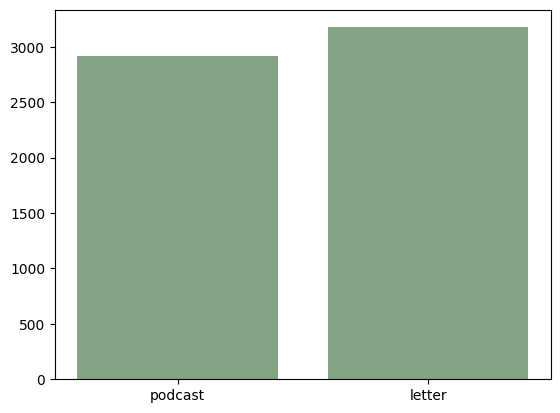

In [8]:
color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 

height = [norm_NoProg_podcast, norm_NoProg_letter]
bars = ('podcast', 'letter')
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height,color=color)

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graphic
plt.savefig('JustAsProgressive.png', dpi=100)
plt.show()

**Write data to file**

In [9]:
with open('JustAsProgressive.csv', newline='', mode = 'w') as csvfile:
    progressive = csv.writer(csvfile, delimiter ='\t')
    progressive.writerows(data)